# Effects of Borrower Characteristics on Loan Amount and Rates

## Investigation Overview

In this investigation, I want to look at the characteristics of a borrower that could be key deciding factors into
the Loan amount they may be eligible to get and the interest rate they could attract.

## Dataset Overview

The dataset consist of information regarding 113,937 loans dispersed by the
prosper loan company, including features like loan term, duration, amount,
creditscore, borrower rate, etc

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# Load in the dataset
df = pd.read_csv('prosperLoanData.csv')

In [3]:
# Convert LoanStatus, CreditGrade and ProsperRating (Alpha) to ordered category

feature_orders = {'LoanStatus':['Cancelled', 'Current', 'Completed', 'FinalPaymentInProgress', 'Past Due (1-15 days)',
                                'Past Due (16-30 days)', 'Past Due (31-60 days)', 'Past Due (61-90 days)',
                                'Past Due (91-120 days)', 'Past Due (>120 days)', 'Chargedoff', 'Defaulted'],
                 'CreditGrade':['AA', 'A', 'B', 'C', 'D', 'E', 'HR'],
                 'ProsperRating (Alpha)':['AA', 'A', 'B', 'C', 'D', 'E', 'HR']}

for col in feature_orders:
    cat_type = pd.api.types.CategoricalDtype(ordered=True, categories=feature_orders[col])
    df[col] = df[col].astype(cat_type)

In [4]:
# Convert date columns to proper type

dates = ['LoanOriginationDate', 'FirstRecordedCreditLine', 'DateCreditPulled']
for date in dates:
    df[date] = pd.to_datetime(df[date])

## Distribution of Loan Amount

The distribution takes on a very wide range from 1000 t0 35000. It congests at the left and becomes scarce down the right. However, there are spikes at intervals of 5000 (e.g. 5000, 10000, 15000, 20000, 25000)

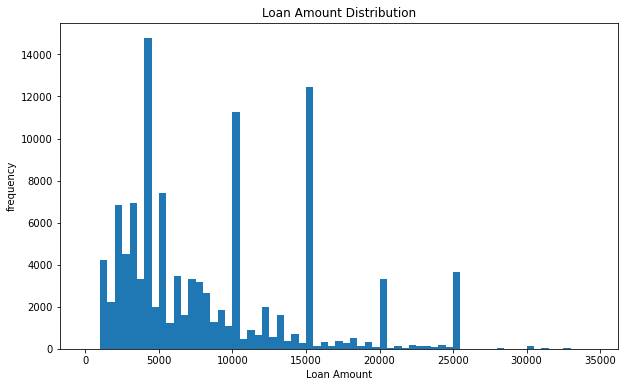

In [5]:
plt.figure(figsize=(10, 6))
la_max = df['LoanOriginalAmount'].max()
bins = np.arange(0, la_max, 500)
plt.hist(df['LoanOriginalAmount'], bins=bins);
plt.xlabel('Loan Amount')
plt.ylabel('frequency')
plt.title('Loan Amount Distribution');

## Distribution of Borrower Rate

Both `BorrowerRate` and `BorrowerAPR` initially appear to ba a normal distribution until a sudden spike in frequency is observed at about 0.32 for the formeer and 0.36 for the latter.

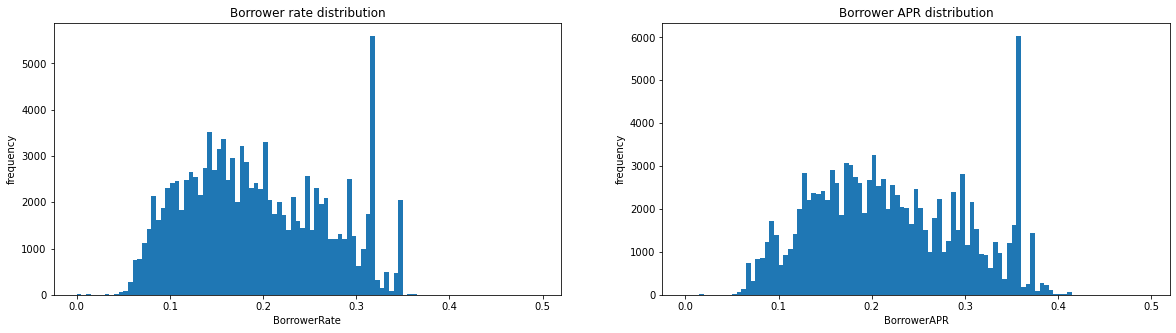

In [6]:
br_max = df['BorrowerRate'].max()
bins = np.arange(0, br_max, 0.005)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.hist(df['BorrowerRate'], bins=bins)
plt.xlabel('BorrowerRate')
plt.ylabel('frequency')
plt.title('Borrower rate distribution')

plt.subplot(1, 2, 2)
plt.hist(df['BorrowerAPR'], bins=bins)
plt.xlabel('BorrowerAPR')
plt.ylabel('frequency')
plt.title('Borrower APR distribution');

## Home Ownership Status vs. Loan Amount

The violin plot reveals something interesting - Borrowers without homes get the bulk of the loan for loan amounts around the 5000 (lower loan amounts) mark. Things seem evenly matched at the 10000 mark but as we proceed higher up the scale,  just above the 10000 mark we see that most of the loans given is designated to borrowers with homes (observe the 15000, 20000, 25000 marks. there's even a little bump at the 35000 mark for the borrower with home category). The box plot shows the median for the distribution of borrowers without homes is much lower than that for borrowers with homes, suggesting a more uniform distribution in the latter than in the former.

in other words, the distribution for borrowers without homes is more congested at the lower part of the scale and very much skewed higher up the scale while the distribution for borrowers with homes is relatively more evenly distributed atleast when compared to the former, although still a little bit skewed higher up the scale.

One could say borrowers with homes are more eligible for higher loan amounts.

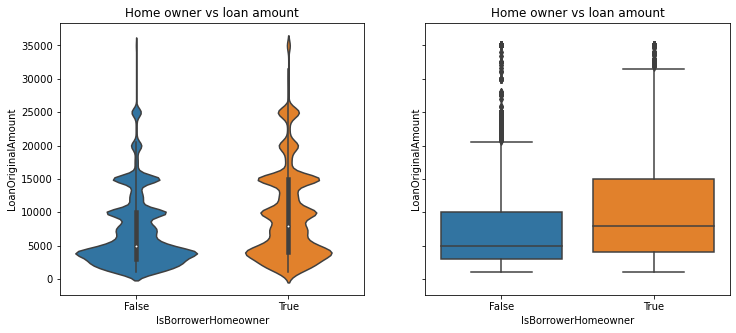

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

sb.violinplot(data=df, x='IsBorrowerHomeowner', y='LoanOriginalAmount', ax=ax[0])
plt.sca(ax[0])
plt.title('Home owner vs loan amount')
sb.boxplot(data=df, x='IsBorrowerHomeowner', y='LoanOriginalAmount', ax=ax[1])
plt.sca(ax[1])
plt.title('Home owner vs loan amount');

## Prosper Rating against Loan Amount by Home Ownership Status

Our observation is hence valid. Homeowners will generally be more eligible for higher loans than non-homeowners. This observation especially stands with borrower of rating 4 (C) or higher.

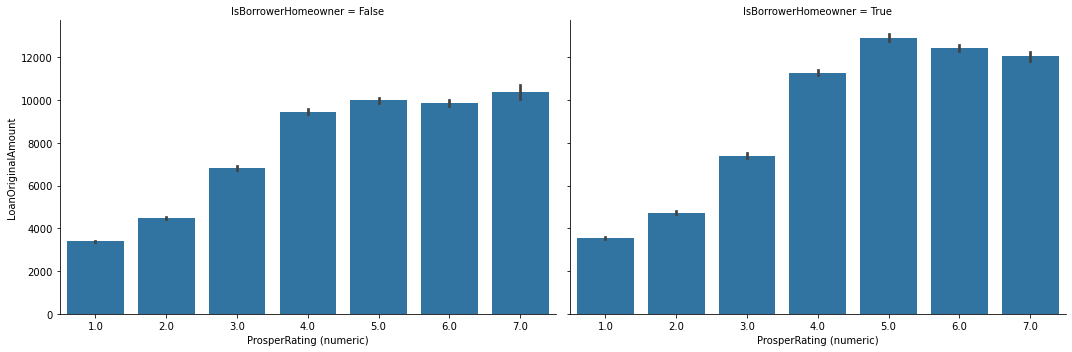

In [8]:
f = sb.FacetGrid(data=df, col='IsBorrowerHomeowner', height=5, aspect=1.5)
f.map(sb.barplot, 'ProsperRating (numeric)', 'LoanOriginalAmount');

## Prosper/Credit Score vs. Loan Original Amount

The Plot shows that the higher the prosper rating of a borrower, the higher the loan amount available to them for borrowing

In [9]:
def creditToNumeric(dts):
    '''
    Encodes alpha categorical values with numeric values suitable for a scatter plot
    '''
    val_dict = {'AA':7, 'A':6, 'B':5, 'C':4, 'D':3, 'E':2, 'HR':1}
    return val_dict[dts]

def mergeCols(dts):
    if dts['CreditGrade na']:
        return dts['CreditGrade (numeric)']
    elif dts['ProsperRating na']:
        return dts['ProsperRating (numeric)']
    else:
        return np.nan

df['CreditGrade (numeric)'] = df['CreditGrade'].apply(creditToNumeric)
df['CreditGrade (numeric)'] = df['CreditGrade (numeric)'].astype('float64')
df['CreditGrade na'] = df['CreditGrade (numeric)'].notna()
df['ProsperRating na'] = df['ProsperRating (numeric)'].notna()

df['ProsperCreditMerge'] = df.loc[:,['ProsperRating (numeric)', 'CreditGrade (numeric)', 'CreditGrade na',
                                     'ProsperRating na']].apply(mergeCols, axis=1)

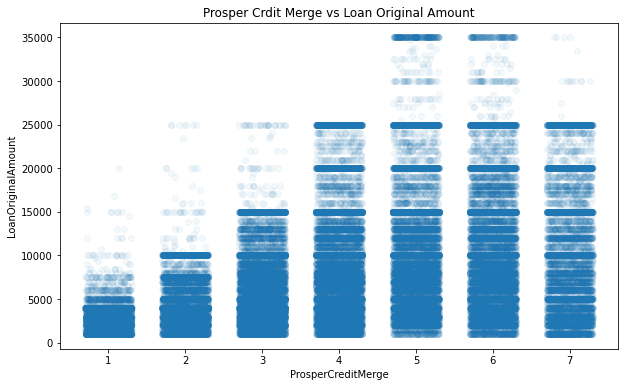

In [10]:
plt.figure(figsize=(10, 6))
sb.regplot(data=df, x='ProsperCreditMerge', y='LoanOriginalAmount', fit_reg=False,
           x_jitter=0.3, scatter_kws={'alpha':1/20});
plt.title('Prosper Crdit Merge vs Loan Original Amount');

## Prosper/Credit Rating vs. Borrower Rate

The violin plot shows clearly that borrowers with higher Prospr/Credit rating generally get more favourable terms on loans as is expected.

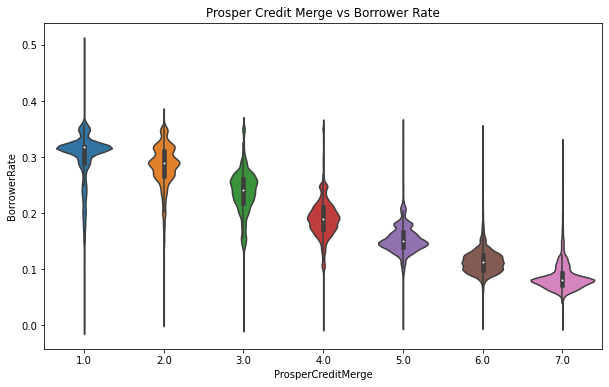

In [11]:
plt.figure(figsize=(10, 6))
sb.violinplot(data=df, x='ProsperCreditMerge', y='BorrowerRate')
plt.title('Prosper Credit Merge vs Borrower Rate');

## LoanOriginalAmount by BorrowerRate and Prosper/Credit Score

This is an interesting plot. It shows again what we have observed recurrently - the higher the borrower prosper rating, the more favourable the borrower rate. It also shows that access to funds over 20,000 is restricted to Borrowers with ratings above 4 (C).

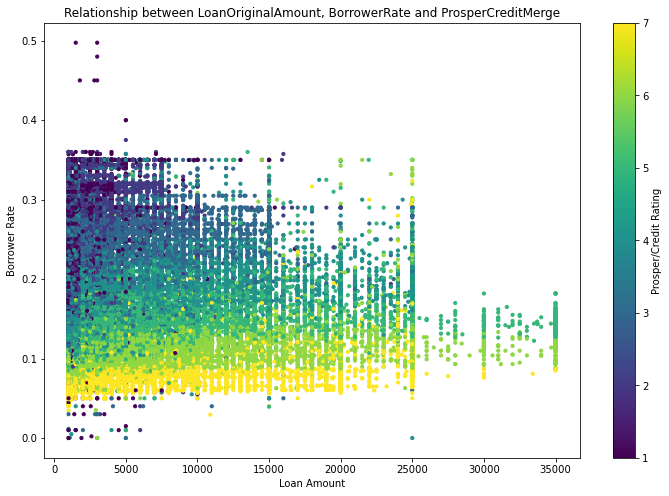

In [12]:
plt.figure(figsize=(12, 8))

plt.scatter(data=df, x='LoanOriginalAmount', y='BorrowerRate', c='ProsperCreditMerge', s=10)
plt.colorbar(label='Prosper/Credit Rating')
plt.xlabel('Loan Amount')
plt.ylabel('Borrower Rate')
plt.title('Relationship between LoanOriginalAmount, BorrowerRate and ProsperCreditMerge');

## LoanOriginalAmount by BorrowerRate with Prosper/Credit Score and Pre/Post 2009

We observe from this plot that the borrower `Rating` became a stronger deciding factor for the `BorrowerRate` after July 2009 as opposed to before this date. Also, after July 2009, the more money a person borrows the lesser the rate they are likely to get. This was not necessarily the case before July 2009.

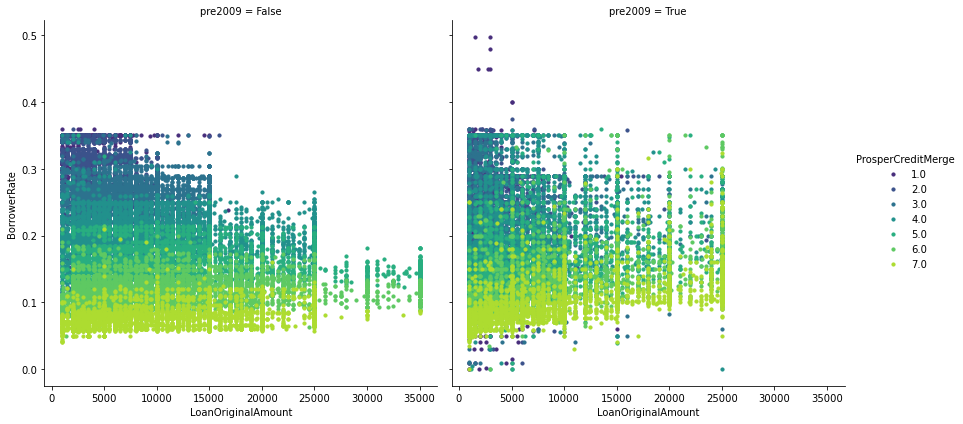

In [13]:
df['pre2009'] = df['LoanOriginationDate'] <= '2009-July'

g = sb.FacetGrid(data=df, col='pre2009', height=6, hue='ProsperCreditMerge', palette='viridis')
g.map(plt.scatter, 'LoanOriginalAmount', 'BorrowerRate', s=10)
g.add_legend();

In [14]:
!jupyter nbconvert prosper_loan_exploration_part_2.ipynb --to slides --post serve --no-input --no-prompt

^C
